In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY= os.getenv("LANGSMITH_API_KEY")

In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama3-8b-8192")

In [5]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [6]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [7]:
workflow = StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)
app = workflow.compile()

In [9]:
from IPython.display import Image, display

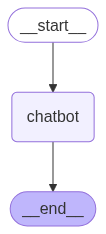

In [ ]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [11]:
app.invoke({"messages":["Hi, my name is Vikas"]})

{'messages': [HumanMessage(content='Hi, my name is Vikas', additional_kwargs={}, response_metadata={}, id='4a0fd2b8-f8b6-48cf-8795-9f1c5695b090'),
  AIMessage(content="Nice to meet you, Vikas! It's great to have you here. Is there something I can help you with or would you like to chat about something in particular?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 17, 'total_tokens': 53, 'completion_time': 0.03, 'prompt_time': 0.003754976, 'queue_time': 0.37214777099999996, 'total_time': 0.033754976}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run--17658572-07db-4543-85e7-6d51880e2ea1-0', usage_metadata={'input_tokens': 17, 'output_tokens': 36, 'total_tokens': 53})]}

In [12]:
input = {"messages":["Hi, my name is Vikas"]}
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from {key} Node")
        print("-----------------")
        print(value)
        print("\n")

Output from chatbot Node
-----------------
{'messages': [AIMessage(content='Nice to meet you, Vikas! How are you doing today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 17, 'total_tokens': 32, 'completion_time': 0.0125, 'prompt_time': 0.003705055, 'queue_time': 0.321368402, 'total_time': 0.016205055}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run--c7291df4-2e99-4829-819b-d01e631126f5-0', usage_metadata={'input_tokens': 17, 'output_tokens': 15, 'total_tokens': 32})]}




In [13]:
@tool
def search(query: str):
    """This is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 30 degrees and foggy."
    return "It's 40 degrees and sunny"

In [14]:
search.invoke("what is the temperatire in sf?")

"It's 30 degrees and foggy."

In [15]:
search.invoke("what is the temperatire in India?")

"It's 40 degrees and sunny"

In [16]:
tools = [search]

In [17]:
tool_node = ToolNode(tools)

In [18]:
llm_with_tool = llm.bind_tools(tools)

In [19]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [26]:
response = call_model({"messages":["hi how are you?"]})

In [27]:
response

{'messages': [AIMessage(content="I'm doing well, thanks for asking!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 1823, 'total_tokens': 1833, 'completion_time': 0.008333333, 'prompt_time': 0.228898853, 'queue_time': -0.283871833, 'total_time': 0.237232186}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'stop', 'logprobs': None}, id='run--796dcd0c-5bc3-40e8-964b-de28b31ccc2c-0', usage_metadata={'input_tokens': 1823, 'output_tokens': 10, 'total_tokens': 1833})]}

In [28]:
response['messages'][-1].tool_calls

[]

In [53]:
response = call_model({"messages":["san francisco"]})

In [54]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b196', 'function': {'arguments': '{"query":"San Francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 900, 'total_tokens': 966, 'completion_time': 0.055, 'prompt_time': 0.11330256, 'queue_time': 0.247466009, 'total_time': 0.16830256}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bd2c93dd-fe94-4174-843a-d2035f20e350-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco'}, 'id': 'call_b196', 'type': 'tool_call'}], usage_metadata={'input_tokens': 900, 'output_tokens': 66, 'total_tokens': 966})]}

In [55]:
response['messages'][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'San Francisco'},
  'id': 'call_b196',
  'type': 'tool_call'}]

In [56]:
response['messages'][-1].content

''

In [59]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [60]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", router_function, {"tools": "tools", END: END})
app = workflow.compile()

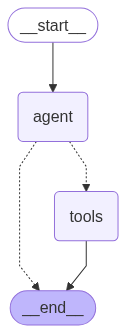

In [61]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [62]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", router_function, {"tools": "tools", END: END})
workflow.add_edge("tools","agent")
app = workflow.compile()

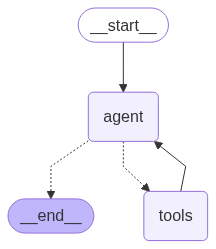

In [63]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [64]:
input = {"messages":["Hi, my name is Vikas"]}
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from {key} Node")
        print("-----------------")
        print(value)
        print("\n")

Output from agent Node
-----------------
{'messages': [AIMessage(content='Nice to meet you, Vikas!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 1827, 'total_tokens': 1836, 'completion_time': 0.0075, 'prompt_time': 0.321145274, 'queue_time': -0.383316334, 'total_time': 0.328645274}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run--f43e5fe8-f45f-4c68-8830-adffe3c3093a-0', usage_metadata={'input_tokens': 1827, 'output_tokens': 9, 'total_tokens': 1836})]}




In [67]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [68]:
workflow2 = StateGraph(MessagesState)

workflow2.add_node("agent", call_model)
workflow2.add_node("tools", tool_node)
workflow2.add_edge(START, "agent")
workflow2.add_conditional_edges("agent", router_function, {"tools":"tools", END:END})
workflow2.add_edge("tools", "agent")

app2 = workflow2.compile(checkpointer = memory)

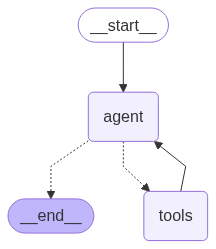

In [69]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [70]:
config = {"configurable": {"thread_id": "1"}}

In [71]:
events = app2.stream({"messages": ["Hi there! My name is Vikas."]}, config, stream_mode="values")

In [72]:
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Vikas.
================================== Ai Message ==================================

Nice to meet you, Vikas!


In [73]:
events = app2.stream({"messages": ["Can you tell me what was my name?"]}, config, stream_mode="values")

In [74]:
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Can you tell me what was my name?
================================== Ai Message ==================================

Your name is Vikas.


In [ ]:
memory.get(config)

{'v': 3,
 'ts': '2025-05-21T07:30:24.501043+00:00',
 'id': '1f036157-5ad9-6d27-8004-f77f884f7985',
 'channel_versions': {'__start__': '00000000000000000000000000000005.0.7251354992701999',
  'messages': '00000000000000000000000000000006.0.18575160816483793',
  'branch:to:agent': '00000000000000000000000000000006.0.6258011566396261'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000004.0.6501332159353587'},
  'agent': {'branch:to:agent': '00000000000000000000000000000005.0.4215322184219624'}},
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Vikas.', additional_kwargs={}, response_metadata={}, id='8b74a237-45cb-46bc-98c8-befa7b379e01'),
   AIMessage(content='Nice to meet you, Vikas!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 906, 'total_tokens': 915, 'completion_time': 0.0075, 'prompt_time': 0.129683957, 'queue_time': 0.41066221299999994, 'total_time': 0.137

In [81]:
memory.get(config)['channel_values']['messages']

[HumanMessage(content='Hi there! My name is Vikas.', additional_kwargs={}, response_metadata={}, id='8b74a237-45cb-46bc-98c8-befa7b379e01'),
 AIMessage(content='Nice to meet you, Vikas!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 906, 'total_tokens': 915, 'completion_time': 0.0075, 'prompt_time': 0.129683957, 'queue_time': 0.41066221299999994, 'total_time': 0.137183957}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'stop', 'logprobs': None}, id='run--385eb9b2-b193-4692-8088-6e1be7ee48ee-0', usage_metadata={'input_tokens': 906, 'output_tokens': 9, 'total_tokens': 915}),
 HumanMessage(content='Can you tell me what was my name?', additional_kwargs={}, response_metadata={}, id='561181ba-0a75-4cd0-bb23-d07e25e97f8d'),
 AIMessage(content='Your name is Vikas.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 933, 'total_tokens': 940, 'completion_